# Cold War Simulation Analysis
## Experiment 2 -- Model variations, book data

In [1]:
import copy
import pickle
import random
from collections import defaultdict, namedtuple, Counter
from itertools import combinations, permutations
import os

import numpy as np
import scipy.stats

import pandas as pd
import networkx as nx
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

# Loading original data

In [2]:
book_data = pd.read_csv("BDM_ColdWar.csv")
book_data.Position = (book_data.Position + 100)/200

In [3]:
book_data.head()

,Country,Capability,Position
0,Argentina,0.972,0.9480
1,Australia,0.889,0.5065
2,Belgium,1.182,0.5140
3,Brazil,0.993,0.9480
4,Bulgaria,0.345,0.0000


# Data serialization

In [4]:
class Model_Output:
    def __init__(self, model):
        '''
        Store data from model run.
        '''
        self.agent_vars = model.datacollector.get_agent_vars_dataframe()
        self.model_vars = model.datacollector.get_model_vars_dataframe()
        self.log = model.log

In [5]:
with open("data_output/ColdWar_Experiment2_1.pickle", "rb") as f:
    model_runs = pickle.load(f)

In [6]:
len(model_runs)

1000

# Analyzing median positions

In [7]:
all_dfs = []
for i, model in enumerate(model_runs):
    df = model.model_vars.copy()
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Step"}, inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)
results = pd.concat(all_dfs)

In [8]:
results.tail()

,Step,Mean,Median,Iteration
20,20,0.757365,0.714067,999
21,21,0.762669,0.714067,999
22,22,0.721636,0.686074,999
23,23,0.812280,0.781000,999
24,24,0.718263,0.700992,999


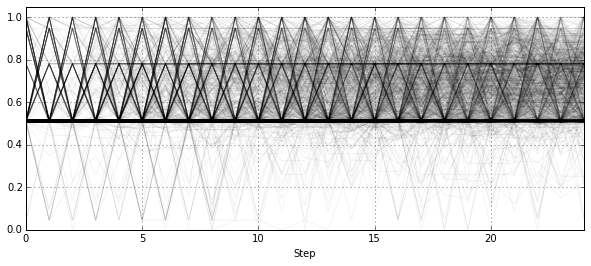

In [9]:
# Plot all runs
fig, ax = plt.subplots(figsize=(10, 4))
for i, group in results.groupby("Iteration"):
    group.plot(x="Step", y="Median", color='k', alpha=0.05, ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.grid(True)

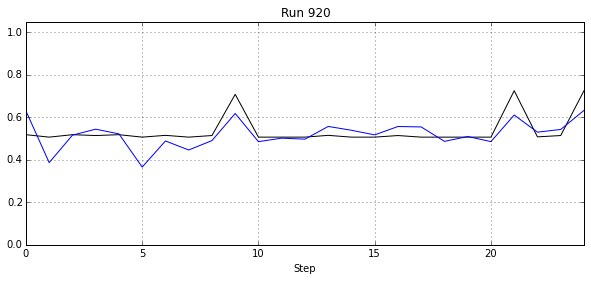

In [10]:
# Pick one trace at random
fig, ax = plt.subplots(figsize=(10, 4))
i = random.randint(0, 999)
subset = results[results.Iteration==i]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

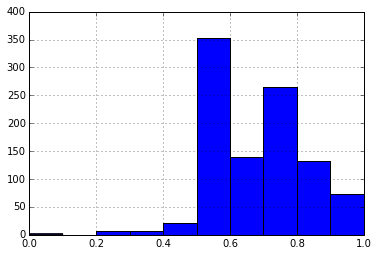

In [11]:
results[results.Step==24]["Median"].hist(bins=np.linspace(0, 1, 11))

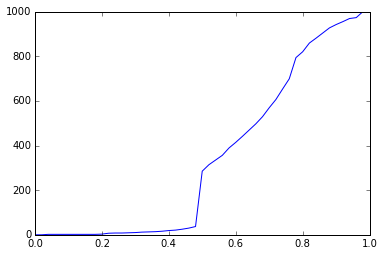

In [12]:
values, base = np.histogram(results[results.Step==24]["Median"], bins=np.linspace(0,1,51))
cdf = np.cumsum(values)
plt.plot(base[:-1], cdf)

In [13]:
import pyobjclipboard
pyobjclipboard.copy_object((base, cdf))

**Look at only runs where the US "wins".**

In [14]:
# Get iterations where US wins
us_win = results[(results.Step==24) & (results.Median>0.8)]["Iteration"].unique()

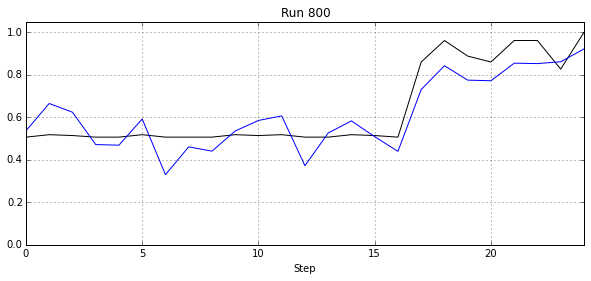

In [15]:
# Plot a random US victory
fig, ax = plt.subplots(figsize=(10, 4))
i = random.choice(us_win)
subset = results[results.Iteration==i]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

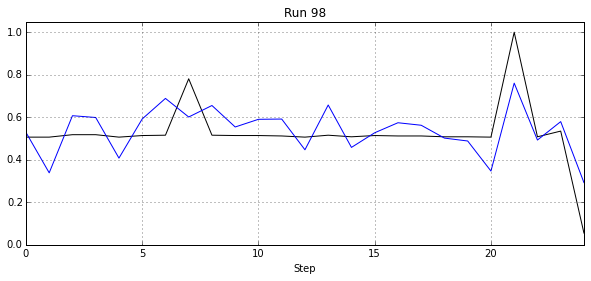

In [16]:
# Get a random instantiation where USSR wins
ussr_win = results[(results.Step==24) & (results.Median<0.2)]["Iteration"].unique()
fig, ax = plt.subplots(figsize=(10, 4))
i = random.choice(ussr_win)
subset = results[results.Iteration==i]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

In [17]:
len(ussr_win)

2

## Deep dive into one run

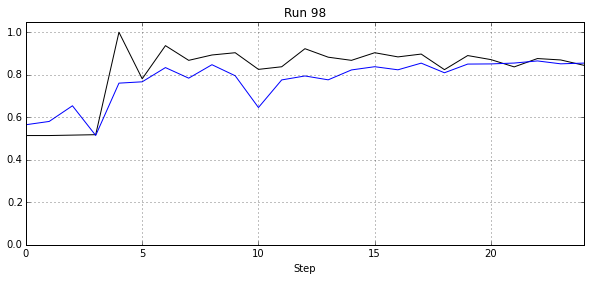

In [18]:
#run_choice = 224
run_choice = 289
fig, ax = plt.subplots(figsize=(10, 4))
subset = results[results.Iteration==run_choice]
subset.plot(x="Step", y="Median", color='k', ax=ax, legend=False)
subset.plot(x="Step", y="Mean", color='b', ax=ax, legend=False)

ax.set_ylim(0, 1.05)
ax.set_title("Run " + str(i))
ax.grid(True)

In [19]:
m = model_runs[run_choice]

In [20]:
agent_positions = m.agent_vars.copy()
agent_positions.reset_index(inplace=True)

(0, 1.05)

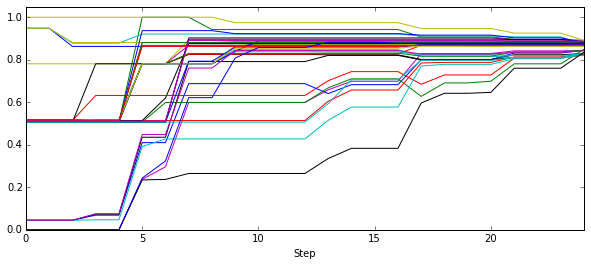

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))

for i, group in agent_positions.groupby("AgentID"):
    group.plot(x="Step", y="Position", ax=ax, legend=False)

ax.set_ylim(0, 1.05)

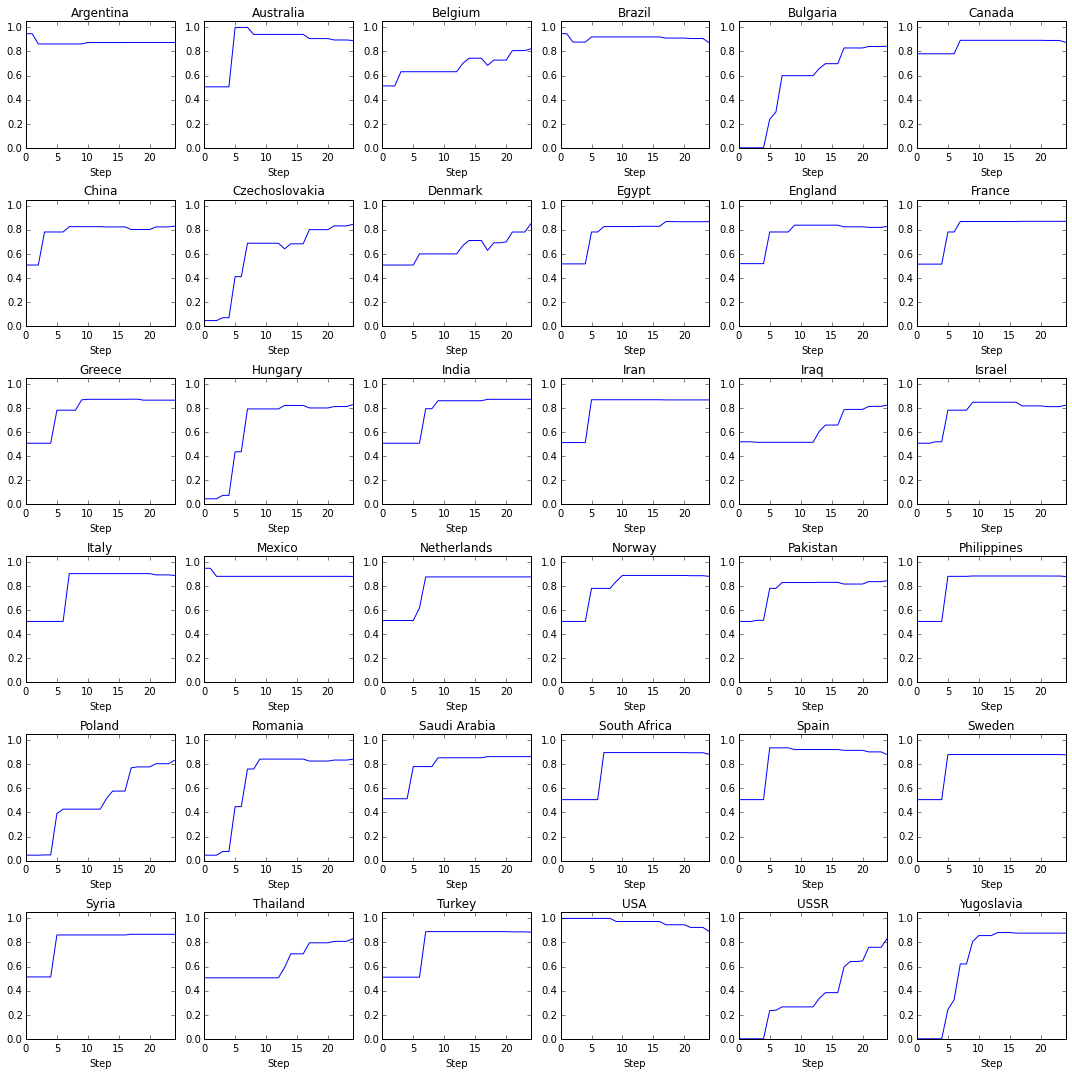

In [22]:
fig = plt.figure(figsize=(15, 15))
fig_num = 1

for name, group in agent_positions.groupby("AgentID"):
    ax = fig.add_subplot(6,6,fig_num)
    group.plot(x="Step", y="Position", ax=ax, legend=False)
    ax.set_title(name)
    ax.set_ylim(0, 1.05)
    fig_num += 1

fig.tight_layout()

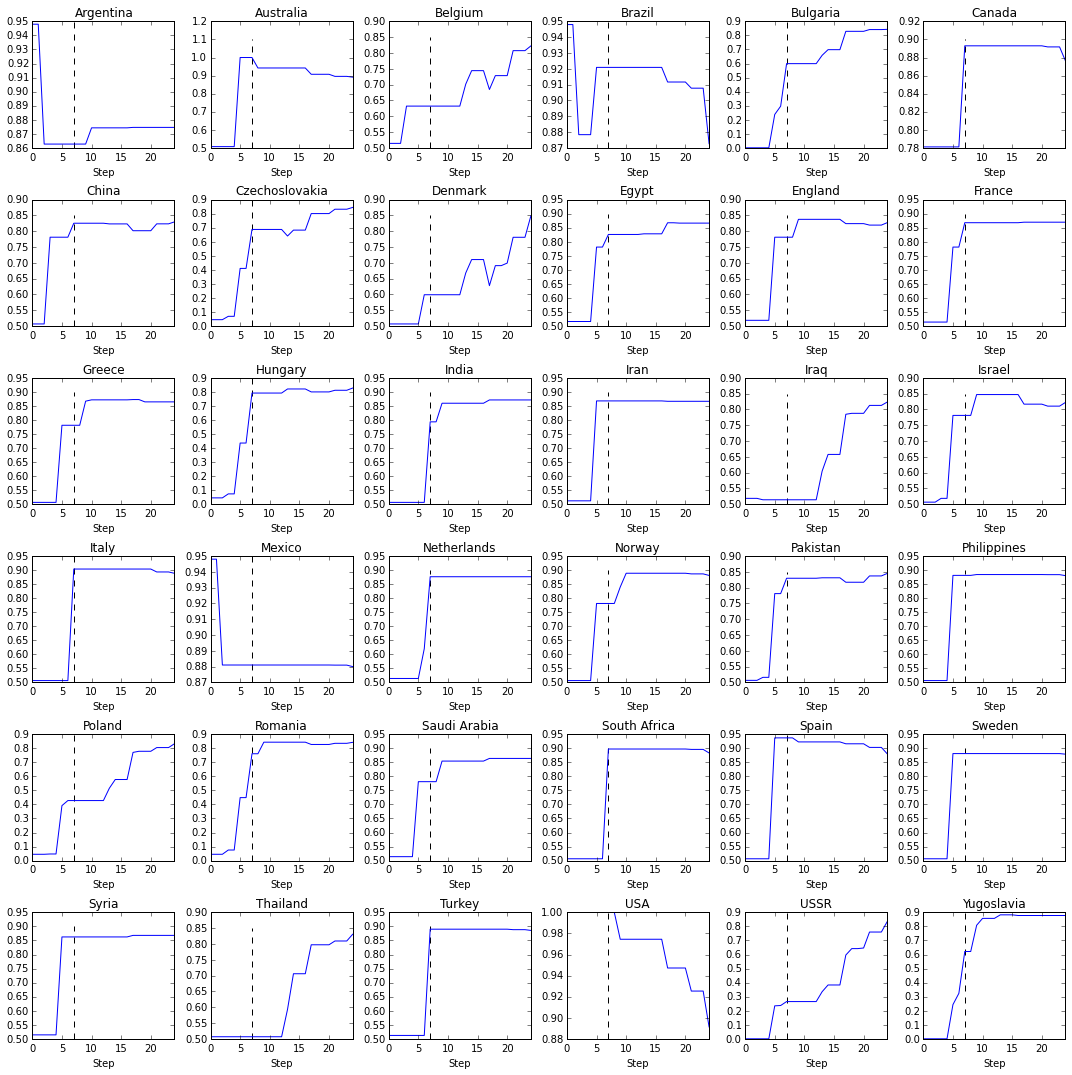

In [23]:
fig = plt.figure(figsize=(15, 15))
fig_num = 1

for name, group in agent_positions.groupby("AgentID"):
    ax = fig.add_subplot(6,6,fig_num)
    group.plot(x="Step", y="Position", ax=ax, legend=False)
    y0, y1 = ax.get_ylim()
    ax.vlines(7, y0, y1, linestyles='--')
    ax.set_title(name)
    # ax.set_ylim(0, 1.05)
    fig_num += 1
    

fig.tight_layout()

In [24]:
fig.savefig("Output.png", dpi=300)

In [25]:
m.log.get_events(action="Attack")

[Event(source='Bulgaria', target='USA', timestamp=0, action='Attack'),
 Event(source='USA', target='Bulgaria', timestamp=0, action='Attack'),
 Event(source='Bulgaria', target='USA', timestamp=1, action='Attack'),
 Event(source='USA', target='Bulgaria', timestamp=1, action='Attack'),
 Event(source='Bulgaria', target='USA', timestamp=2, action='Attack'),
 Event(source='USA', target='Bulgaria', timestamp=2, action='Attack'),
 Event(source='Bulgaria', target='USA', timestamp=3, action='Attack'),
 Event(source='USA', target='Bulgaria', timestamp=3, action='Attack'),
 Event(source='China', target='Greece', timestamp=11, action='Attack'),
 Event(source='Greece', target='China', timestamp=11, action='Attack'),
 Event(source='USSR', target='USA', timestamp=11, action='Attack'),
 Event(source='USA', target='USSR', timestamp=11, action='Attack'),
 Event(source='Hungary', target='USA', timestamp=14, action='Attack'),
 Event(source='USA', target='Hungary', timestamp=14, action='Attack'),
 Event(sou

In [26]:
# Average unweighted postion

In [27]:
average_position = agent_positions.groupby("Step").aggregate("mean")

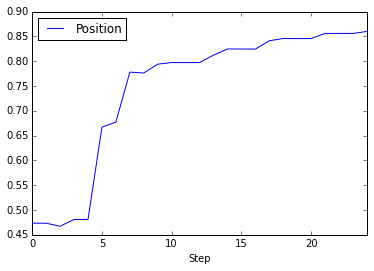

In [28]:
average_position.plot()

# Agent position analysis

In [29]:
all_dfs = []
for i, model in enumerate(model_runs):
    df = model.agent_vars.copy()
    df.reset_index(inplace=True)
    df["Iteration"] = i
    all_dfs.append(df)
agent_positions = pd.concat(all_dfs)

## How far do agents end up from their starting position?

In [30]:
end_positions = agent_positions[agent_positions.Step==24]\
    .groupby("AgentID")["Position"].aggregate([np.mean, np.std])

end_positions = end_positions.rename(columns={"mean": "EndPos_mean",
                             "std": "EndPos_std"})

In [31]:
end_positions = end_positions.merge(book_data, left_index=True, right_on="Country")

In [32]:
end_positions.EndPos_std.mean()

0.17186567610339665

In [33]:
end_positions["Delta"] = end_positions.EndPos_mean - end_positions.Position

0.161026737351
-0.132931747869
0.455783100774


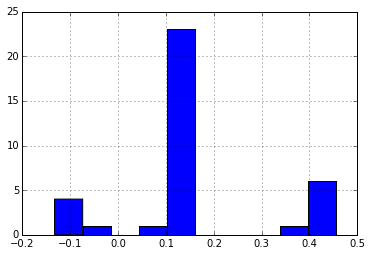

In [34]:
print(end_positions.Delta.mean())
print(end_positions.Delta.min())
print(end_positions.Delta.max())
end_positions.Delta.hist()

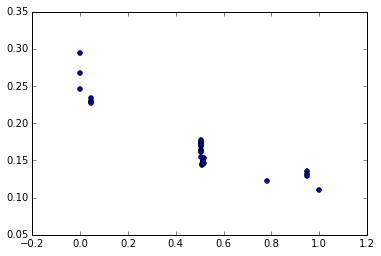

In [35]:
plt.scatter(end_positions.Position, end_positions.EndPos_std)

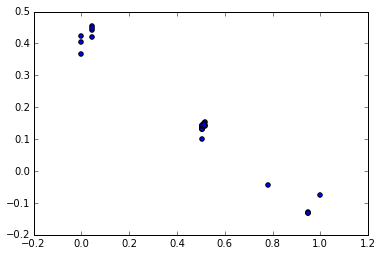

In [36]:
plt.scatter(end_positions.Position, end_positions.Delta)

In [37]:
end_positions.corr()

,EndPos_mean,EndPos_std,Capability,Position,Delta
EndPos_mean,1.000000,-0.913240,0.144910,0.977752,-0.933803
EndPos_std,-0.913240,1.000000,-0.092758,-0.907601,0.877822
Capability,0.144910,-0.092758,1.000000,0.134039,-0.122273
Position,0.977752,-0.907601,0.134039,1.000000,-0.988079
Delta,-0.933803,0.877822,-0.122273,-0.988079,1.000000


In [38]:
end_positions.corr(method='spearman')

,EndPos_mean,EndPos_std,Capability,Position,Delta
EndPos_mean,1.000000,-0.909138,-0.086369,0.958512,-0.400000
EndPos_std,-0.909138,1.000000,-0.073369,-0.932844,0.480824
Capability,-0.086369,-0.073369,1.000000,0.030859,-0.233492
Position,0.958512,-0.932844,0.030859,1.000000,-0.507119
Delta,-0.400000,0.480824,-0.233492,-0.507119,1.000000


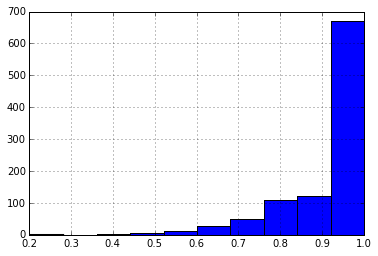

In [39]:
agent_positions[(agent_positions.AgentID=="USA") & 
                (agent_positions.Step==24)]["Position"].hist()

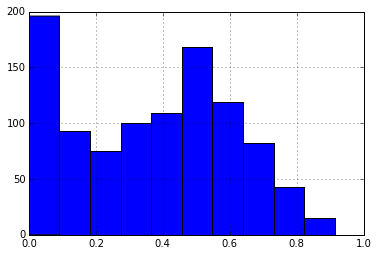

In [40]:
agent_positions[(agent_positions.AgentID=="USSR") & 
                (agent_positions.Step==24)]["Position"].hist()

# Conflict frequencies

In [41]:
actors = book_data.Country.unique()

In [42]:
model.model_vars.Median[24]

0.70099169056008503

In [43]:
conflict_dyads = Counter()
conflict_models = defaultdict(set)

for i, model in enumerate(model_runs):
    if model.model_vars.Median[24] < 0.75:
        continue
    for event in model.log.get_events(action="Attack"):
        if event.timestamp > 25: # Max steps to consider
            continue
        source = event.source
        target = event.target
        dyad = (source, target)
        if (target, source) in conflict_dyads:
            dyad = (target, source)
        conflict_dyads[dyad] += 0.5
        conflict_models[dyad].add(i)

conflict_models = {k: len(v) for k, v in conflict_models.items()}        
        
# Fill in zeroes
for source, target in permutations(actors, 2):
    dyad = (source, target)
    if (target, source) in conflict_dyads:
        dyad = (target, source)
    if dyad not in conflict_dyads:
        conflict_dyads[dyad] = 0
    if dyad not in conflict_models:
        conflict_models[dyad] = 0

In [44]:
conflict_dyads.most_common(20)

[(('Bulgaria', 'USA'), 2057.0),
 (('USSR', 'USA'), 661.0),
 (('USA', 'Yugoslavia'), 429.0),
 (('China', 'USA'), 146.0),
 (('England', 'USSR'), 91.0),
 (('Australia', 'USA'), 77.0),
 (('Poland', 'USA'), 73.0),
 (('China', 'England'), 73.0),
 (('Bulgaria', 'England'), 72.0),
 (('Czechoslovakia', 'USA'), 70.0),
 (('Bulgaria', 'Canada'), 70.0),
 (('Australia', 'England'), 64.0),
 (('Romania', 'USA'), 63.0),
 (('England', 'USA'), 61.0),
 (('Canada', 'USA'), 59.0),
 (('Australia', 'Canada'), 50.0),
 (('Australia', 'Bulgaria'), 48.0),
 (('Argentina', 'Australia'), 44.0),
 (('Argentina', 'Bulgaria'), 44.0),
 (('England', 'Yugoslavia'), 44.0)]

## Load MID data

In [45]:
COW = "/Users/dmasad/Data/COW/"
mid_a = pd.read_csv(COW + "MIDA_4.01.csv")
mid_b = pd.read_csv(COW + "MIDB_4.01.csv")

In [46]:
start_year = 1948
end_year = 1998
#end_year = 1948 + 5

mid_a = mid_a[(mid_a.StYear >= start_year) & (mid_a.StYear <= end_year)]
mid_b = mid_b[(mid_b.StYear >= start_year) & (mid_b.StYear <= end_year)]

### Get state names

In [47]:
state_names = pd.read_csv(COW + "SystemMembership2011/states2011.csv")
#state_names = state_names[["stateabb", "statenme"]]
state_names = state_names[["ccode", "statenme"]]
state_names.drop_duplicates(inplace=True)

In [48]:
name_dict = state_names.set_index("statenme").to_dict()["ccode"]

In [49]:
for name in book_data.Country.unique():
    if name not in name_dict:
        print(name)

England
USSR
USA


In [50]:
state_names.replace("United Kingdom", "England", inplace=True)
state_names.replace("United States of America", "USA", inplace=True)
state_names.replace("Russia", "USSR", inplace=True)

In [51]:
#mid_b2 = mid_b.merge(state_names, how="left", left_on="ccode", right_on="stateabb")
mid_b = mid_b.merge(state_names, how="left", on="ccode")

In [52]:
observed_mids = defaultdict(int)
for dispnum, group in mid_b.groupby("DispNum3"):
    sides = {}
    for side, rows in group.groupby("SideA"):
        sides[side] = rows.statenme.unique()
    # Build dyads
    for side_a in sides[0]:
        for side_b in sides[1]:
            observed_mids[(side_a, side_b)] += 1
            observed_mids[(side_b, side_a)] += 1
observed_mids = dict(observed_mids)

In [53]:
observed_mids = pd.DataFrame({"Observed_MIDs": observed_mids})
observed_mids.reset_index(inplace=True)
observed_mids.rename(columns={"level_0": "Source_Country",
                               "level_1": "Target_Country"}, inplace=True)

### Merge

In [54]:
predicted_conflicts = pd.DataFrame({"Predicted_Conflicts": dict(conflict_dyads)})
predicted_conflicts.reset_index(inplace=True)
predicted_conflicts.rename(columns={"level_0": "Source_Country",
                               "level_1": "Target_Country"}, inplace=True)

In [55]:
conflicts = predicted_conflicts.merge(observed_mids, 'left', 
                                      on=["Source_Country", "Target_Country"])
conflicts.fillna(0, inplace=True)

In [70]:
conflicts.Predicted_Conflicts /= 1000

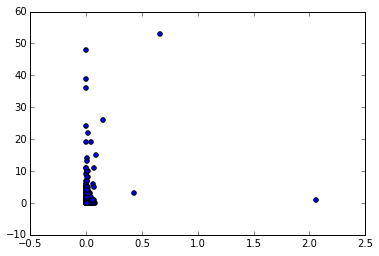

In [71]:
plt.scatter(conflicts.Predicted_Conflicts, conflicts.Observed_MIDs)

In [72]:
conflicts.corr()

,Predicted_Conflicts,Observed_MIDs,Const.,MID_Dummy,PredictedConflicts_Dummy
Predicted_Conflicts,1.000000,0.168018,NaN,0.127555,0.061312
Observed_MIDs,0.168018,1.000000,NaN,0.462268,0.035367
Const.,NaN,NaN,NaN,NaN,NaN
MID_Dummy,0.127555,0.462268,NaN,1.000000,0.101810
PredictedConflicts_Dummy,0.061312,0.035367,NaN,0.101810,1.000000


In [58]:
conflicts["Const."] = 1

In [83]:
lm = sm.OLS(conflicts.Observed_MIDs, conflicts[["Const.", "Predicted_Conflicts"]])
fit = lm.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:          Observed_MIDs   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     18.24
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           2.25e-05
Time:                        09:04:27   Log-Likelihood:                -1814.0
No. Observations:                 630   AIC:                             3632.
Df Residuals:                     628   BIC:                             3641.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Const.                  1.0137    

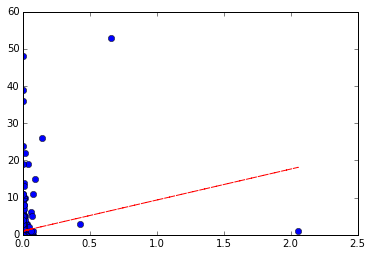

In [85]:
fig, ax = plt.subplots()
plt.plot(conflicts.Predicted_Conflicts, conflicts.Observed_MIDs, 'o')
plt.plot(conflicts.Predicted_Conflicts, fit.fittedvalues, 'r--')

In [74]:
with open("lm_ex_2.pickle", "wb") as f:
    pickle.dump(fit, f)

In [75]:
conflicts["MID_Dummy"] = 0
conflicts["MID_Dummy"][conflicts.Observed_MIDs > 0] = 1

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [76]:
logit = sm.Logit(conflicts.MID_Dummy, conflicts[["Const.", "Predicted_Conflicts"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.521441
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              MID_Dummy   No. Observations:                  630
Model:                          Logit   Df Residuals:                      628
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Dec 2015   Pseudo R-squ.:                 0.03683
Time:                        14:56:57   Log-Likelihood:                -328.51
converged:                       True   LL-Null:                       -341.07
                                        LLR p-value:                 5.388e-07
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Const.                 -1.4216      0.111    -12.812      0.000        -1.639    -1.204
Pr

In [77]:
with open("logit_ex_2.pickle", "wb") as f:
    pickle.dump(fit, f)

In [78]:
conflicts["PredictedConflicts_Dummy"] = 0
conflicts["PredictedConflicts_Dummy"][conflicts.Predicted_Conflicts>0] = 1

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [79]:
logit = sm.Logit(conflicts.MID_Dummy, conflicts[["Const.", "PredictedConflicts_Dummy"]])
fit = logit.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.535709
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              MID_Dummy   No. Observations:                  630
Model:                          Logit   Df Residuals:                      628
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Dec 2015   Pseudo R-squ.:                 0.01047
Time:                        14:57:00   Log-Likelihood:                -337.50
converged:                       True   LL-Null:                       -341.07
                                        LLR p-value:                  0.007530
                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Const.                      -1.8124      0.270     -6.722      0.000        -2.3

In [86]:
conflicts.to_csv("transfer/conflict_df_ex2.csv")

# Top conflict dyads

In [80]:
conflict_pairs = conflicts[["Source_Country", "Target_Country", 
                            "Predicted_Conflicts", "Observed_MIDs"]].copy()

In [81]:
conflict_pairs.sort("Predicted_Conflicts", ascending=False).head(10).to_clipboard()

In [82]:
conflict_pairs.sort("Observed_MIDs", ascending=False).head(10)

,Source_Country,Target_Country,Predicted_Conflicts,Observed_MIDs
628,USSR,USA,0.661,53
471,Israel,Syria,0.001,48
406,India,Pakistan,0.001,39
286,Egypt,Israel,0.000,36
221,China,USA,0.146,26
420,Iran,Iraq,0.002,24
202,China,India,0.020,22
373,Greece,Turkey,0.001,19
222,China,USSR,0.039,19
328,England,USSR,0.091,15
